# Dataset Statistics for Gene Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel, make_sentence_df

# Read Full Sentence Table

The cells below will read every sentence that contains a gene and disease entity from the sentence table in our postgres database. For time sake majority of the data has already been processed and save as files mentioned below.

In [ ]:
sql= '''
select id as sentence_id, text, (
    char_length(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g')) - 
    char_length(regexp_replace(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g'), ',', '','g'))
) as sen_length, entity_types 
from sentence 
where entity_types::text like '%%Gene%%' or entity_types::text like '%%Gene%%';
'''
sentence_df = pd.read_sql(sql, database_str)
sentence_df.head(2)

In [ ]:
entity_data = []
tagging_error_ids = set({})

#skip tagging error
skip_tag_error = False
for index, row in tqdm_notebook(sentence_df.iterrows()):
    
    #create dictionay for mapping entity types
    entity_mapper = {"sentence_id": row['sentence_id']}
    
    #Keep track of previous entity
    previous_entity = 'o'
    
    #For all entitys in a given sentence decide what is tagged
    for entity in row['entity_types']:
        entity = entity.lower()

        #Non-O tag
        if entity != 'o' and previous_entity =='o':
            #If entity not seen before instanciate it
            if entity not in entity_mapper:
                entity_mapper[entity] =0
            entity_mapper[entity] += 1

        # If previous tag was non-O and the current tag does not equal previous
        # Then tagging error. e.x. Disease, Gene, Disease instead of Disease, O, Disease
        elif entity != previous_entity and entity != 'o':
            tagging_error_ids.add(row['sentence_id'])
            skip_tag_error = True
            break

        previous_entity = entity
    
    # Do not add errors to dataframe
    # They will be thrown out
    if not skip_tag_error:
        entity_data.append(entity_mapper)

    skip_tag_error=False
    
entity_stats_df = pd.DataFrame.from_dict(entity_data).fillna(0)
entity_stats_df.head(2)

In [ ]:
tagging_error_df = pd.Series(sorted(list(tagging_error_ids)))
tagging_error_df.to_csv("data/tagging_error_ids.tsv.xz", sep="\t",  index=False, compression="xz")
tagging_error_df.head(2)

In [ ]:
print(
    "Total Number of IOB Tagging Errors: {}. Percentage of sentences affected: {:.2f}".format(
        tagging_error_df.shape[0],
        100*tagging_error_df.shape[0]/sentence_df.shape[0]
    )
)

In [ ]:
header = ["sentence_id", "text", "sen_length"]
sentence_df[header].to_csv("data/sentence_stats.tsv.xz", sep="\t", index=False, compression="xz")
entity_stats_df.to_csv("data/entity_stats.tsv.xz", sep="\t",  index=False, compression="xz")

# Sentence Counts and Statistics

Below is the block of code that contains information about the full distribution of sentences tied to each candidate pair. Multiple sentences can contain more than one co-occuring pair, which results in some sentences being counted more than once.

## Load and Merge DataFrames

In [5]:
entity_level_df = pd.read_table("../gene_interacts_gene.tsv.xz")
entity_level_df.head(2)

,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432
1,125,ADH1B,10321,CRISP3,NaN,1,0,1,3,0.664368


In [6]:
entity_stats_df = pd.read_table("data/entity_stats.tsv.xz")
entity_stats_df.head(2)

,compound,disease,gene,sentence_id
0,0.0,1.0,1,50851796
1,0.0,0.0,1,50851806


In [7]:
sentence_count_df = pd.read_table("data/sentence_stats.tsv.xz")
sentence_count_df.head(2)

,sentence_id,text,sen_length
0,50851796,In this study we aimed to characterize the vir...,28
1,50851806,HLA-A2 tetramers were used to identify HBV-spe...,18


In [8]:
sentence_sql = '''
select cand_id, "Gene1_cid" as gene1_id, "Gene2_cid" as gene2_id, sentence_id from (
    select gene_gene.id as "cand_id", gene_gene."Gene1_id",
    gene_gene."Gene1_cid", gene_gene."Gene2_cid", candidate.split from gene_gene 
    inner join candidate on gene_gene.id=candidate.id 
    where split={}
) as candidate_splits inner join span on candidate_splits."Gene1_id"=span.id;
'''

In [9]:
train_candidate_df = pd.read_sql(sentence_sql.format(3), database_str)
train_candidate_df.head(2)

,cand_id,gene1_id,gene2_id,sentence_id
0,550462,3630,3630,4177301
1,964979,3558,4155,5709292


In [10]:
dev_candidate_df = pd.read_sql(sentence_sql.format(4), database_str)
test_candidate_df = pd.read_sql(sentence_sql.format(5), database_str)

In [11]:
clean_up_df = lambda x: (
        entity_stats_df
        .merge(sentence_count_df, on="sentence_id")
        .merge(x, on="sentence_id")
        .rename(index=str, columns={
            "disease":"disease_mention_count", 
            "gene":"gene_mention_count", 
            "compound":"compound_mention_count",
            "cand_id": "candidate_id"
        })
    )

In [12]:
train_candidate_df = clean_up_df(train_candidate_df)
train_candidate_df.head(2)

,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id,gene1_id,gene2_id
0,0.0,0.0,2,50851817,At all time points there was sequestering of H...,33,14633063,925,925
1,0.0,0.0,2,50851817,At all time points there was sequestering of H...,33,14633058,925,925


In [13]:
dev_candidate_df = clean_up_df(dev_candidate_df)
test_candidate_df = clean_up_df(test_candidate_df)

In [14]:
training_set_df = (
    entity_level_df
    .query("split==3&has_sentence==1")
    .merge(
        train_candidate_df.astype({"gene1_id":int, "gene2_id":int}), 
        on=["gene1_id", "gene2_id"]
    )
)
training_set_df.head(2)

,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,2,65570963,Human CRISP-3 binds serum alpha(1)B-glycoprote...,11,20992573
1,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,3,65570968,BACKGROUND: CRISP-3 was previously shown to be...,21,20930188


In [15]:
dev_set_df = (
    entity_level_df
    .query("split==4&has_sentence==1")
    .merge(
        dev_candidate_df.astype({"gene1_id":int, "gene2_id":int}), 
        on=["gene1_id", "gene2_id"]
    )
)

test_set_df = (
    entity_level_df
    .query("split==5&has_sentence==1")
    .merge(
        test_candidate_df.astype({"gene1_id":int, "gene2_id":int}), 
        on=["gene1_id", "gene2_id"]
    )
)

In [16]:
total_candidates_df = (
    training_set_df
    .append(dev_set_df)
    .append(test_set_df)
    .drop_duplicates("candidate_id")
)

In [ ]:
dev_candidates = (
    session
    .query(GeneGene)
    .filter(
        GeneGene.id.in_(
            total_candidates_df
            .query("split==4")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
dev_df = make_sentence_df(dev_candidates)
dev_df.head(2)

In [ ]:
test_candidates = (
    session
    .query(GeneGene)
    .filter(
        GeneGene.id.in_(
            total_candidates_df
            .query("split==5")
            .sample(10000, random_state=120)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
test_df = make_sentence_df(test_candidates)
test_df.head(2)

In [ ]:
write_candidates_to_excel(dev_df, "data/sentence_labels_dev.xlsx")
write_candidates_to_excel(test_df, "data/sentence_labels_test.xlsx")

## Distribution of Sentence Length

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


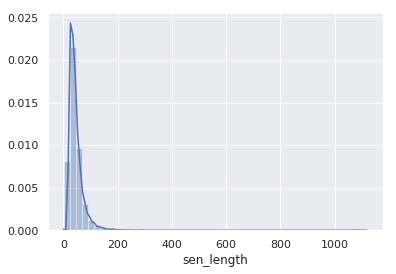

In [17]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [18]:
total_candidates_df["sen_length"].describe().astype(int)

count    13929222
mean           44
std            27
min             2
25%            28
50%            38
75%            53
max          1120
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the thousands range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 37. Possible reason for this abnormality is a parsing error. Lets take a look at this 1120 word sentence.

In [19]:
total_candidates_df.query("sen_length==1120").iloc[0]["text"]

'Pooled analysis of (R)-[11C]-verapamil PET data from two European centresM Bauer, M Feldmann, R Karch, W Wadsak, M Zeitlinger, MJ Koepp, M-C Asselin, E Pataraia, O LangerA13 In-vitro and in-vivo characterization of [18F]FE@SNAP and derivatives for the visualization of the melanin concentrating hormone receptor 1M Zeilinger, C Philippe, M Dumanic, F Pichler, J Pilz, M Hacker, W Wadsak, M MitterhauserA14 Reducing time in quality control leads to higher specific radioactivity of short-lived radiotracersL Nics, B Steiner, M Hacker, M Mitterhauser, W WadsakA15 In vitro 11C-erlotinib binding experiments in cancer cell lines with epidermal growth factor receptor mutationsA Traxl, Thomas Wanek, Kushtrim Kryeziu, Severin Mairinger, Johann Stanek, Walter Berger, Claudia Kuntner, Oliver LangerA16 7-[11C]methyl-6-bromopurine, a PET tracer to measure brain Mrp1 function: radiosynthesis and first PET evaluation in miceS Mairinger, T Wanek, A Traxl, M Krohn, J Stanek, T Filip, M Sauberer, C Kuntner,

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


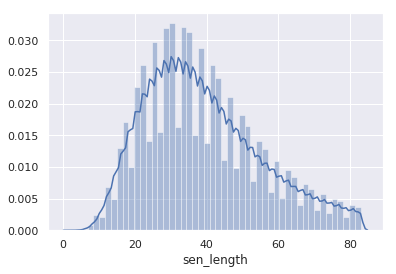

In [20]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [21]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    12933682
mean           38
std            16
min             2
25%            27
50%            36
75%            49
max            83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 12.9 million.

In [22]:
before_filter = set([tuple(line) for line in total_candidates_df[["gene1_id", "gene2_id"]].values])
after_filter = set([tuple(line) for line in total_candidates_df.query("sen_length < 83+1")[["gene1_id", "gene2_id"]].values])
print(
    "Total number of unique candidates before filter: {}".format(
        total_candidates_df[["gene1_id", "gene2_id"]].drop_duplicates().shape[0]
    )
)
print(
    "Total number of unique candidates after filter: {}".format(
        total_candidates_df.query("sen_length < 83+1")[["gene1_id", "gene2_id"]].drop_duplicates().shape[0]
    )
)
print("Total number of unique candidates being thrown out: {}".format(len(before_filter.difference(after_filter))))

Total number of unique candidates before filter: 1283694
Total number of unique candidates after filter: 1161808
Total number of unique candidates being thrown out: 121886


In [23]:
filtered_total_candidates_df = total_candidates_df.query("sen_length < 83+1")

Text(0.5,1,'# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet')

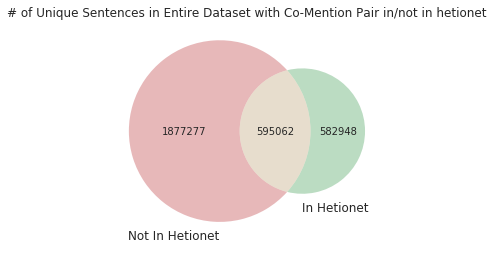

In [24]:
venn2(
    [
        set(filtered_total_candidates_df.query("hetionet==0").sentence_id),
        set(filtered_total_candidates_df.query("hetionet==1").sentence_id)
    ], set_labels=["Not In Hetionet", "In Hetionet"])
plt.title("# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet")

# Co-occuring Mentions Sentence Stats

This next block contains a visualization about the number of mentions a sentence may contain.

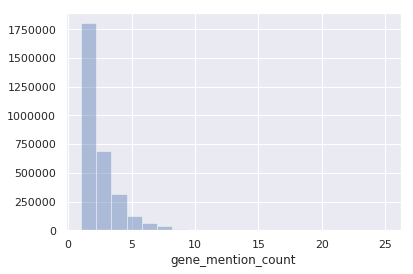

In [25]:
sns.distplot(
    filtered_total_candidates_df
    .drop_duplicates("sentence_id")["gene_mention_count"], 
    kde=False, 
    rug=False,
    bins=20
)

In [26]:
filtered_total_candidates_df.drop_duplicates("sentence_id")["gene_mention_count"].value_counts()

2     1787332
3      690090
4      319388
5      124060
6       61925
7       26364
1       15269
8       14147
9        7182
10       4065
11       2142
12       1307
13        831
14        441
15        286
16        172
17        107
18         64
19         44
20         32
21         19
22         12
24          3
23          3
25          2
Name: gene_mention_count, dtype: int64

The above graph shows the distribution of gene mentions per sentence. Looking above majority of the sentences contain only two unique gene mentions, while a select number of sentences can contain a total of 25 gene mentions. Overall, this is an acceptable distribution, since majority of sentences will have just two mention pairs.

# Subsampled Set Distributions

Take a look at the stratification for each train/dev/test set.

## Training Set

Here the training set covers majority of the characterisitics are the entire dataset. This isn't surprising because a stratified sort was used to allocate candidates.

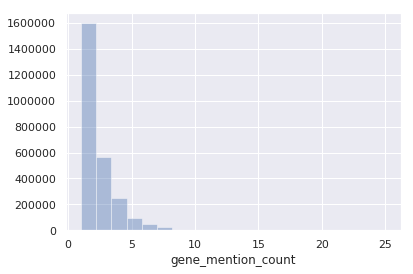

In [27]:
sns.distplot(
    filtered_total_candidates_df
    .query("split==3")
    .drop_duplicates("sentence_id")["gene_mention_count"], 
    kde=False, 
    rug=False,
    bins=20
)

In [28]:
filtered_total_candidates_df.query("split==3").drop_duplicates("sentence_id")["gene_mention_count"].value_counts()

2     1584430
3      567033
4      249606
5       93078
6       45594
7       18863
1       13262
8       10092
9        5034
10       2864
11       1501
12        919
13        583
14        310
15        200
16        130
17         82
18         46
19         35
20         21
21         14
22          9
24          2
23          2
25          1
Name: gene_mention_count, dtype: int64

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


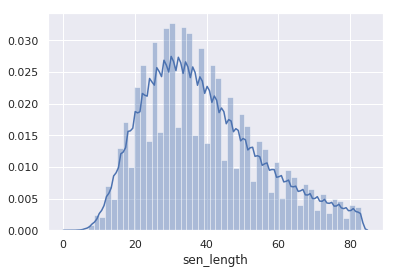

In [29]:
sns.distplot(filtered_total_candidates_df.query("split==3")["sen_length"], rug=False)

## Dev Set

This block contains information on the development set (aka tuning set).

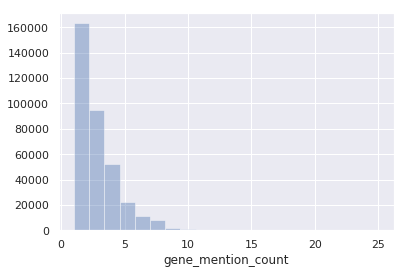

In [30]:
sns.distplot(
    filtered_total_candidates_df
    .query("split==4")
    .drop_duplicates("sentence_id")["gene_mention_count"], 
    kde=False, 
    rug=False,
    bins=20
)

In [31]:
filtered_total_candidates_df.query("split==4").drop_duplicates("sentence_id")["gene_mention_count"].value_counts()

2     161547
3      94914
4      52055
5      22425
6      11496
7       5197
8       2791
1       1666
9       1484
10       854
11       439
12       265
13       171
14        85
15        64
16        28
17        14
18        12
20         8
19         6
21         4
22         3
24         1
23         1
25         1
Name: gene_mention_count, dtype: int64

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


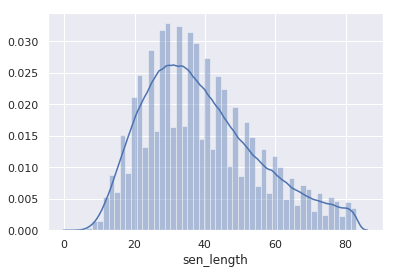

In [32]:
sns.distplot(filtered_total_candidates_df.query("split==4")["sen_length"], rug=False)

## Test Set

This block contains information on the test set.

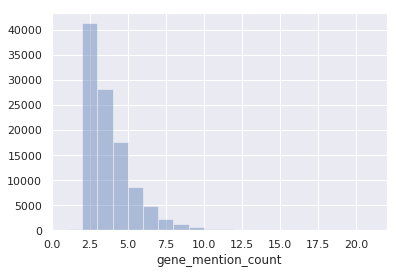

In [33]:
sns.distplot(
    filtered_total_candidates_df
    .query("split==5")
    .drop_duplicates("sentence_id")["gene_mention_count"], 
    kde=False, 
    rug=False,
    bins=20
)

In [34]:
filtered_total_candidates_df.query("split==5").drop_duplicates("sentence_id")["gene_mention_count"].value_counts()

2     41355
3     28143
4     17727
5      8557
6      4835
7      2304
8      1264
9       664
10      347
1       341
11      202
12      123
13       77
14       46
15       22
16       14
17       11
18        6
20        3
19        3
21        1
Name: gene_mention_count, dtype: int64

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


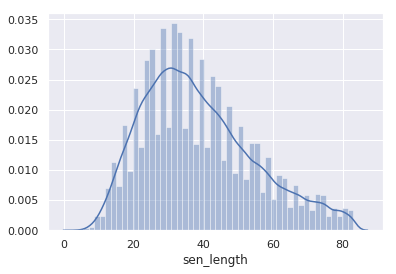

In [35]:
sns.distplot(filtered_total_candidates_df.query("split==5")["sen_length"], rug=False)

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 1120 words, then the network has 1120 steps to parse through. This takes a significant amount of time (~34 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 